In [13]:
import torch
from infowavegan import WaveGANGenerator
import numpy as np
import matplotlib.pyplot as plt
import librosa as lb
import scipy.signal
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.signal import spectrogram
from IPython.lib.display import Audio
import IPython
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = "C:/Users/Jayde/Desktop/wavegan/scpy1/epoch1700_step54400_G.pt"
G = WaveGANGenerator(slice_len=16384)
G.load_state_dict(torch.load(model_dir, map_location=device))
G.to(device)
N= 200
nCat = 5

In [14]:
_z = torch.FloatTensor(N, 100 - nCat).uniform_(-1, 1).to(device)
c = torch.FloatTensor(N, nCat).to(device)
z = torch.cat((c, _z), dim=1)
z[:, :nCat] = 0

In [15]:
bits = range(nCat)
#ts = np.linspace(-0.9, 12.5, Nts)
ts = np.arange(-1,10,1)
batchSize = 64
sr = 16000
audio = []
doses = []
bit_vals = []
fundamental_freqs = []
f0_stds = []
df = pd.DataFrame()
for bit in bits:
        print(f"Generating for bits {bit}, N={N}, {len(ts)} values of t...")

        z[:, :nCat] = 0

        for t in ts:
            print(f"Generating for bit={bit}, N={N}, t={t}")
            z[:, bit] = t
            f0s = []

            for zPart in z.split(batchSize, dim=0):
                print("split")
                # 1st async level - filter
                generated = G(zPart).detach().cpu().flatten(start_dim=1, end_dim=2).numpy()
                audio.append(generated)
                f0s += avg_fundamental_freq(generated, sr = sr)
            f0_avg = np.average(f0s)
            f0_std = np.std(f0s)
    
            doses.append(t)
            bit_vals.append(bit)
            fundamental_freqs.append(f0_avg)
            f0_stds.append(f0_std)
df['bit'] = bit_vals
df['dose'] = doses
df['f0'] = fundamental_freqs
df['f0 std'] = f0_stds
#df.to_csv(f"{model_dir}/Bits.csv", index= False)

Generating for bits 0, N=200, 11 values of t...
Generating for bit=0, N=200, t=-1
split
split
split
split
Generating for bit=0, N=200, t=0
split
split
split
split
Generating for bit=0, N=200, t=1
split
split
split
split
Generating for bit=0, N=200, t=2
split
split
split
split
Generating for bit=0, N=200, t=3
split
split
split
split
Generating for bit=0, N=200, t=4
split
split
split
split
Generating for bit=0, N=200, t=5
split
split
split
split
Generating for bit=0, N=200, t=6
split
split
split
split
Generating for bit=0, N=200, t=7
split
split
split
split
Generating for bit=0, N=200, t=8
split
split
split
split
Generating for bit=0, N=200, t=9
split
split
split
split
Generating for bits 1, N=200, 11 values of t...
Generating for bit=1, N=200, t=-1
split
split
split
split
Generating for bit=1, N=200, t=0
split
split
split
split
Generating for bit=1, N=200, t=1
split
split
split
split
Generating for bit=1, N=200, t=2
split
split
split
split
Generating for bit=1, N=200, t=3
split
split
sp

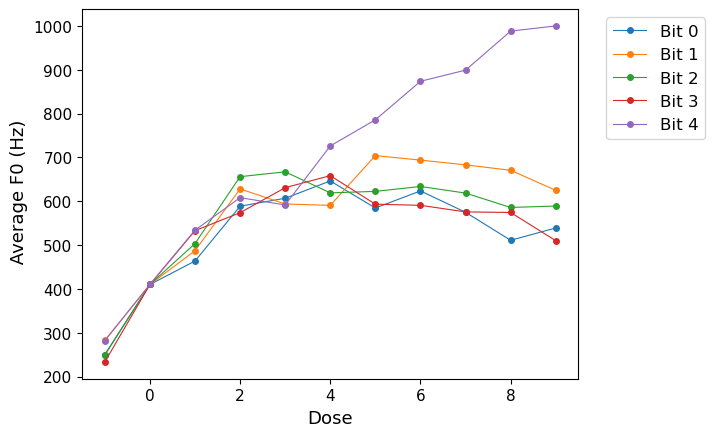

In [16]:
for bit in range(nCat):
    bit_data = df.loc[df['bit'] ==bit]
    plt.plot(bit_data['dose'], bit_data['f0'], '-o', markersize = 4,linewidth =0.8, label = f"Bit {bit}")
    #plt.errorbar(bit_data['dose'], bit_data['f0'], yerr=bit_data['f0 std dev'], marker = 'o',markersize = 4,linewidth =0.8, label = f"Bit {bit}")
plt.xlabel("Dose", fontsize = 13)
plt.ylabel(" Average F0 (Hz)", fontsize = 13)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", fontsize =12)
#plt.legend(fontsize =12)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
#plt.ylim(0,3000)
plt.savefig("F0_bits_e_1700.png", dpi= 300, bbox_inches = "tight", transparent = True)
plt.show()

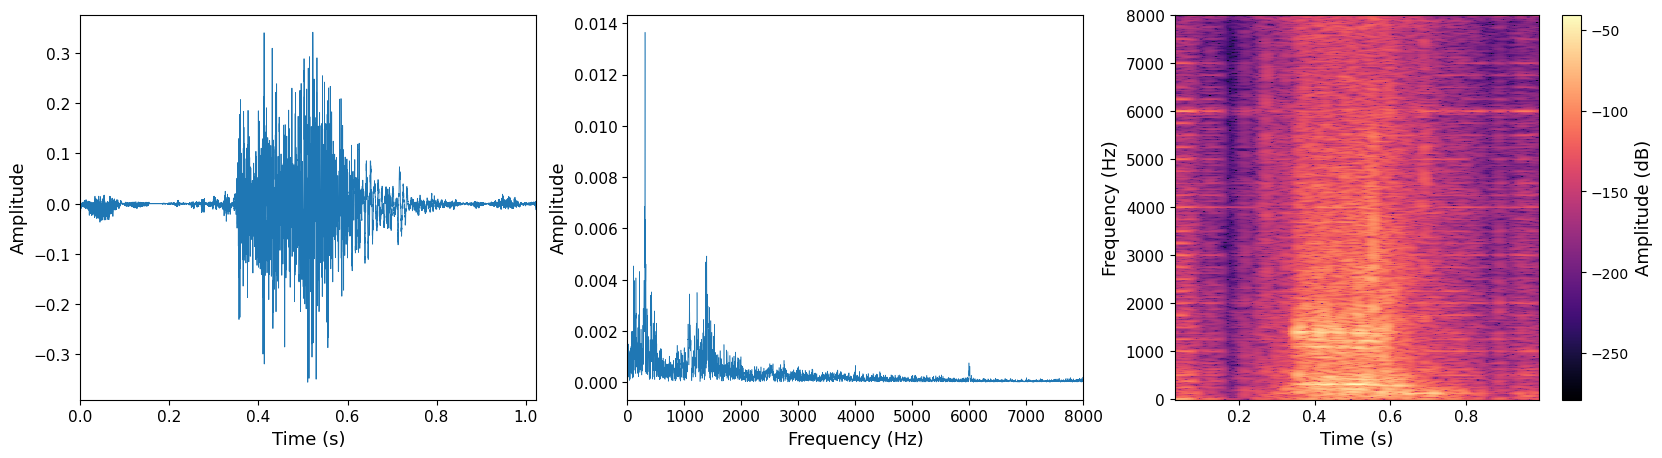

In [23]:
signal =audio[2][20]
sr=16000
create_plots(signal,sr)
IPython.display.display(Audio(signal, rate =sr))

In [13]:
def create_plots(signal, sr, window_length = 1024, save_dir = None, lw=0.6, fmax=6e3, font_size = 13, amp_envelope= False, plot_rms = False):
    fmax = sr/2 #nyquist frequency 
    N = len(signal)
    delta_t = 1 / sr
    times = np.arange(0, N) / sr
    signalf = fft(signal)
    freqs = np.linspace(0.0, 1.0/(2.0*delta_t), N//2)
    
    fig, axs = plt.subplots(1,3, figsize=(20,5))
    axs[0].plot(times, signal, linewidth=lw)
    #axs[0].librosa.display.waveshow(code_1[1], sr=sr)
    axs[0].set_xlabel('Time (s)', fontsize= font_size)
    axs[0].set_ylabel('Amplitude', fontsize = font_size)
    #t_ae, ae = amplitude_envelope(signal,frame_size = 128, hop_length= 64, sr= sr)
    #t_rms, rms = RMS_energy(signal,frame_size = 128, hop_length= 64, sr= sr)
    axs[0].plot(t_ae,ae, color = "r") if amp_envelope else None
    axs[0].plot(t_rms,rms, color = "r") if plot_rms else None
    axs[0].set_xlim(0,max(times))
    #axs[0].set_title('Time Domain Representation')
    #axs[0].xticks(fontsize = font_size)
    #axs[0].yticks(fontsize= font_size)
    
    axs[1].plot(freqs, 2.0/N * np.abs(signalf[0:N//2]), linewidth=0.4)
    axs[1].set_xlabel('Frequency (Hz)', fontsize= font_size)
    axs[1].set_ylabel('Amplitude', fontsize= font_size)
    #axs[1].set_title('Frequency Domain Representation')
    axs[1].set_xlim([0, fmax])
    #axs[1].xticks(fontsize = font_size)
    #axs[1].yticks(fontsize= font_size)


    f_bins, t_bins, Sxx = spectrogram(signal, fs=sr,
                                 window='hann', nperseg=window_length,
                                 noverlap=window_length-64, detrend=False,
                                 scaling='spectrum')
    im = axs[2].pcolormesh(t_bins, f_bins, 20*np.log10(Sxx+1e-100), cmap='magma')

    axs[2].set_xlabel('Time (s)', fontsize= font_size)
    axs[2].set_ylabel('Frequency (Hz)', fontsize= font_size)
    #axs[2].set_xlim(0,1)
    #axs[2].xticks(fontsize = font_size)
    #axs[2].yticks(fontsize= font_size)
    #axs[2].set_title(f'STFT with nperseg={window_length}')

    # Add colorbar
    cbar = fig.colorbar(im, ax=axs[2])
    cbar.set_label('Amplitude (dB)',fontsize= font_size)
    for ax in axs:
        ax.tick_params(axis='both', labelsize=font_size-2)
    
    if save_dir:
        plt.savefig(save_dir, dpi= 300, bbox_inches = "tight", transparent = True)
    plt.show()

In [3]:
def avg_fundamental_freq(inputs, sr):
    freqs = []
    for signal in inputs:
        n_samples = len(signal)
        amplitudes = np.abs(rfft(signal))
        frequencies = rfftfreq(n_samples, 1/sr)
        fundamental_freq_index = np.argmax(amplitudes)
        fundamental_freq= frequencies[fundamental_freq_index]
        freqs.append(fundamental_freq)
    #avg= np.average(freqs)
    #std = np.std(freqs)
    return freqs